In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/MyDrive/SLIIT/Research Project/

/content/gdrive/MyDrive/SLIIT/Research Project


Need to convert 'Net Credit granted to the Government (NCG)' into float.

In [3]:
#import relevant libraries
import numpy as np
import pandas as pd

#import the csv file to extract data
df=pd.read_csv('Money_printing.csv')
df=df.dropna() #drop null values
print('Shape of data',df.shape)

# define a function to remove comma and convert to float
def remove_comma_and_convert_to_float(s):
    s = s.replace(',', '')
    f = float(s)
    return f


#apply the function to the entire column
df['Money_Printing'] = df['Money_Printing'].apply(remove_comma_and_convert_to_float)

#drop duplicates
dup_sum=df.duplicated(subset='Month').sum()
print("duplicates : ", dup_sum)



Shape of data (325, 2)
duplicates :  0


Since the date formats are not the same for all the records, records are adjusted to be in a single format.

In [4]:
import re
import datetime

# Replace the additional parts with an empty string since Month records contain additional simbols & letters.
df['Month'] = df['Month'].str.replace(r'(\s*\(\w+\))', '')

# Trim any leading/trailing whitespace characters
df['Month'] = df['Month'].str.strip()

date_pattern = r'\b\w{3}-\d{2}\b'
mm_yy_dates = [date for date in df['Month'] if re.match(date_pattern, date)] #Take all the elements that are in the format of mm-yy.

# Define the function to convert month-year dates into year-month
def convert_month_date(date_str):
  month = date_str[:3]  # Extract the first two characters as month
  year = date_str[-2:]  # Extract the last two characters as year
  date_str = year + '-' + month  # Reformat the date string as yy-mm
  print(date_str)
  return date_str

# calling the function
converted_dates = [convert_month_date(date) for date in mm_yy_dates]

# Iterate over mm_yy_dates and replace the values in the DataFrame with the values in converted_dates where we have the dates with corrected format. (yy-mm)
for mm_yy_date in mm_yy_dates:
    mm_yy_month, mm_yy_year = mm_yy_date.split('-')  # Split the mm-yy date into month and year
    print("month : " + mm_yy_month + "year : " + mm_yy_year )
    converted_date = next((date for date in converted_dates if date[-3:] == mm_yy_month and date[:2] == mm_yy_year), None)
    print("converted date : " + converted_date)
    if converted_date:
      df.loc[df['Month'] == mm_yy_date, 'Month'] = converted_date

95-Dec
96-Jan
96-Feb
96-Mar
96-Apr
96-May
96-Jun
96-Jul
96-Aug
96-Sep
96-Oct
96-Nov
96-Dec
97-Jan
97-Feb
97-Mar
97-Apr
97-May
97-Jun
97-Jul
97-Aug
97-Sep
97-Oct
97-Nov
97-Dec
98-Jan
98-Feb
98-Mar
98-Apr
98-May
98-Jun
98-Jul
98-Aug
98-Sep
98-Oct
98-Nov
98-Dec
99-Jan
99-Feb
99-Mar
99-Apr
99-May
99-Jun
99-Jul
99-Aug
99-Sep
99-Oct
99-Nov
99-Dec
00-Jan
00-Feb
00-Mar
00-Apr
00-May
00-Jun
00-Jul
00-Aug
00-Sep
00-Oct
00-Nov
00-Dec
15-Oct
22-Mar
22-Apr
22-May
22-Oct
month : Decyear : 95
converted date : 95-Dec
month : Janyear : 96
converted date : 96-Jan
month : Febyear : 96
converted date : 96-Feb
month : Maryear : 96
converted date : 96-Mar
month : Apryear : 96
converted date : 96-Apr
month : Mayyear : 96
converted date : 96-May
month : Junyear : 96
converted date : 96-Jun
month : Julyear : 96
converted date : 96-Jul
month : Augyear : 96
converted date : 96-Aug
month : Sepyear : 96
converted date : 96-Sep
month : Octyear : 96
converted date : 96-Oct
month : Novyear : 96
converted date : 96-No

<ipython-input-4-d5777ad3749b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Month'] = df['Month'].str.replace(r'(\s*\(\w+\))', '')


In [5]:
#Add 0 for years where only one digit exists.
df['Month'] = df['Month'].str.replace(r'\b(\d{1})\b', r'0\1', regex=True)

#change the datatype into datetime
df['Month'] = pd.to_datetime(df['Month'], format='%y-%b')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Month                                       325 non-null    datetime64[ns]
 1   Net Credit granted to the Government (NCG)  325 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


LEt us standarize the dataset

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the 'Money_Printing_Values' column
df['Money_Printing'] = scaler.fit_transform(df['Money_Printing'].values.reshape(-1, 1))

# The 'Money_Printing_Values' column is now standardized to the [0, 1] scale
df.head()

,Month,Money_Printing
0,1995-12-01,0.000193
1,1996-01-01,0.000480
2,1996-02-01,0.000405
3,1996-03-01,0.000859
4,1996-04-01,0.000789


Split the dataset into training & testing sets

In [7]:
# train-test split for time series

df = df[["Money_Printing"]].values.astype(np.float32)  # Convert to float32
#train_size = int(len(df) * 0.67)
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]

New windows created before creating the model.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#Transform a time series into a prediction dataset
#dataset: A numpy array of time series, first dimension is the time steps
#lookback: Size of window for prediction
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
        print(feature)
        print(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

[[0.0001929]]
[[0.00047983]]
[[0.00047983]]
[[0.0004049]]
[[0.0004049]]
[[0.00085944]]
[[0.00085944]]
[[0.00078855]]
[[0.00078855]]
[[0.00132528]]
[[0.00132528]]
[[0.00061031]]
[[0.00061031]]
[[0.00038634]]
[[0.00038634]]
[[0.00064771]]
[[0.00064771]]
[[0.00059982]]
[[0.00059982]]
[[0.00068013]]
[[0.00068013]]
[[0.00087545]]
[[0.00087545]]
[[0.00133214]]
[[0.00133214]]
[[0.00134627]]
[[0.00134627]]
[[0.00132219]]
[[0.00132219]]
[[0.00159997]]
[[0.00159997]]
[[0.00193371]]
[[0.00193371]]
[[0.00235059]]
[[0.00235059]]
[[0.0025934]]
[[0.0025934]]
[[0.0022914]]
[[0.0022914]]
[[0.]]
[[0.]]
[[0.00071779]]
[[0.00071779]]
[[0.00114785]]
[[0.00114785]]
[[0.00080779]]
[[0.00080779]]
[[0.00107911]]
[[0.00107911]]
[[0.00150231]]
[[0.00150231]]
[[0.00157885]]
[[0.00157885]]
[[0.00152235]]
[[0.00152235]]
[[0.00177821]]
[[0.00177821]]
[[0.00192228]]
[[0.00192228]]
[[0.00192712]]
[[0.00192712]]
[[0.00252869]]
[[0.00252869]]
[[0.00212809]]
[[0.00212809]]
[[0.00240682]]
[[0.00240682]]
[[0.00296158]]
[[0

<ipython-input-8-d0be3edc213d>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


In [ ]:
#LSTM model creation
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

#calling the function
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

#Train the model in an iteration
n_epochs = 5000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0474, test RMSE 0.4154
Epoch 100: train RMSE 0.0027, test RMSE 0.0107
Epoch 200: train RMSE 0.0027, test RMSE 0.0229
Epoch 300: train RMSE 0.0028, test RMSE 0.0338
Epoch 400: train RMSE 0.0027, test RMSE 0.0394
Epoch 500: train RMSE 0.0027, test RMSE 0.0439
Epoch 600: train RMSE 0.0029, test RMSE 0.0442
Epoch 700: train RMSE 0.0035, test RMSE 0.0414
Epoch 800: train RMSE 0.0029, test RMSE 0.0474
Epoch 900: train RMSE 0.0028, test RMSE 0.0463
Epoch 1000: train RMSE 0.0027, test RMSE 0.0513
Epoch 1100: train RMSE 0.0028, test RMSE 0.0542
Epoch 1200: train RMSE 0.0041, test RMSE 0.0515
Epoch 1300: train RMSE 0.0027, test RMSE 0.0550
Epoch 1400: train RMSE 0.0027, test RMSE 0.0585
Epoch 1500: train RMSE 0.0038, test RMSE 0.0574
Epoch 1600: train RMSE 0.0027, test RMSE 0.0619
Epoch 1700: train RMSE 0.0028, test RMSE 0.0683
Epoch 1800: train RMSE 0.0028, test RMSE 0.0687
Epoch 1900: train RMSE 0.0036, test RMSE 0.0679
Epoch 2000: train RMSE 0.0028, test RMSE 0.0732
Epoc

Plot the actual data & predicted data.

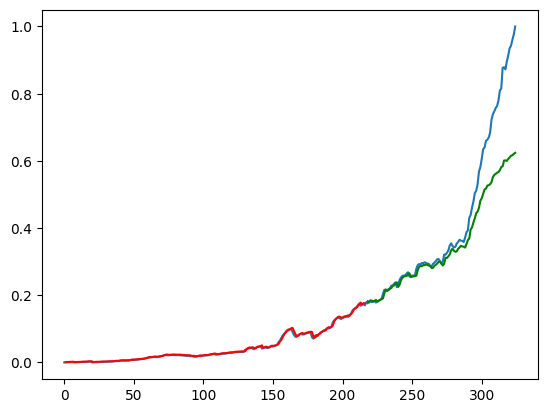

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df) * np.nan
    test_plot[train_size+lookback:len(df)] = model(X_test)[:, -1, :]
# plot
plt.plot(df)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()